In [1]:
import sys
import os
import h5py
from collections import Counter
from progressbar import *
import re
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from functools import reduce
import matplotlib.pyplot as plt
from collections import OrderedDict 
import time
np.set_printoptions(threshold=sys.maxsize)

In [5]:
#Read in true hits and digitized hits
trueHitsPath = "/fast_scratch/WatChMaL/data/IWCD_mPMT_Short_pi0_E0to1000MeV_truehits.h5"
digiHitsPath = "/fast_scratch/WatChMaL/data/IWCD_mPMT_Short_pi0_E0to1000MeV_digihits.h5"

trueHitsFile = h5py.File(trueHitsPath,"r")
digiHitsFile =h5py.File(digiHitsPath,"r")

#Load pmt hit information from both true source and digitized source
trueHitPmt    = trueHitsFile["hit_pmt"]
trueHitTime   = trueHitsFile["hit_time"]
trueHitParent = trueHitsFile["hit_parent"]

digiHitPmt    = digiHitsFile["hit_pmt"]
digiHitTime   = digiHitsFile["hit_time"]
digiHitCharge = digiHitsFile["hit_charge"]

print(digiHitCharge[:100])

#Look at event ids
ns = 0
ne = 3000
n = ne-ns
trueEvents = trueHitsFile["event_ids"][ns:ne]
digiEvents = digiHitsFile["event_ids"][ns:ne]


'''
index = np.where(digiEvents==10)[0][0]
print(index)
print(digiEvents[index])
print(digiEvents[index-1])

print(len(trueEvents),len(digiEvents))
print(trueEvents,digiEvents)
'''

[ 94.11696     31.907393    67.41104     10.022707     3.5113757
   1.4529723   23.906609     4.7313      14.680437    23.743343
   0.6020345   11.885519     2.5556543    1.335148     0.9075044
   5.1592493   31.371778     0.628339     1.471897     1.9507533
   1.720974     0.5635009   12.138962     1.3835369    1.4602696
   2.1499043    1.1376551    2.4315574    1.4524624    0.90669525
   0.8174193    1.6968968    6.824797     2.5338948    1.2409676
   2.4677489    2.3915746    0.50541973   9.414818     1.0003828
   0.23834775   1.355052     3.8346353    3.7078304    1.2820184
  63.20679      0.49180123   6.935998     5.4783134   11.478033
   6.726526     1.1408178  156.44382      2.2260804    2.1137834
  10.185053     7.380881     2.9573712    2.1243064    2.168279
   1.2121977    0.8052004    1.0878187    1.1337544    1.2681174
   1.2056674    0.32842195   5.960671     1.7452239    0.60470355
   2.7554276    0.38002807   4.0399914    2.985395     2.3516138
   5.358996     1.932537  

'\nindex = np.where(digiEvents==10)[0][0]\nprint(index)\nprint(digiEvents[index])\nprint(digiEvents[index-1])\n\nprint(len(trueEvents),len(digiEvents))\nprint(trueEvents,digiEvents)\n'

In [147]:
#### Loop through all events, log errors in array ####

#Uses n events previously defined

errorArr = []
absErrorArr = []
sumDiff = []
lastEvent = ns

#Note this is actually calculating the previous event
#ie for event 15, we are actually analyzing the previous event since event_hits_index gives the starting index
for event in digiEvents[1:]:
    #print(event)
    
    #Find the starting index
    startDigiIndex = digiHitsFile["event_hits_index"][np.where(digiEvents==lastEvent)[0][0]]
    startTrueIndex = trueHitsFile["event_hits_index"][lastEvent]

    #Find the ending true/digitize indices for each event
    endDigiIndex = digiHitsFile["event_hits_index"][np.where(digiEvents==event)[0][0]]
    endTrueIndex = trueHitsFile["event_hits_index"][event]

    #Retrieve array of corresponding hit pmt's (indices will be different)
    digiHitPmt = digiHitsFile["hit_pmt"][startDigiIndex:endDigiIndex]
    trueHitPmt = trueHitsFile["hit_pmt"][startTrueIndex:endTrueIndex]
    
    #Vectorized operation to count the number of instances of each unique true hit pmt there are
    #This counts_elements array should very closely match up with the charge on the corresponding pmts
    uniqueElements, countsElements = np.unique(trueHitPmt, return_counts=True)
    
    #print(uniqueElements)
    #print(digiHitPmt)
    
    #Retrieve array of charges for each hit pmt
    digiHitCharge = digiHitsFile["hit_charge"][startDigiIndex:endDigiIndex]

    #Digitized dictionary
    digiDict = dict(zip(digiHitPmt,digiHitCharge))
    digiDict = dict(sorted(digiDict.items())) 

    #True dictionary
    trueDict = dict(zip(uniqueElements,countsElements))
    trueDict = {x: trueDict[x] for x in digiDict.keys()}
    
    #Set last event
    lastEvent = event
    
    #Calculate the mean error and % error
    sumVals = 0
    sumAbsVals = 0
    for pmt in trueDict.keys():
        sumVals += abs((trueDict[pmt]-digiDict[pmt])/trueDict[pmt])
        sumAbsVals += abs((trueDict[pmt]-digiDict[pmt]))

    errorArr.append(sumVals/len(trueDict.keys()))
    absErrorArr.append(sumAbsVals/len(trueDict.keys()))
    sumDiff.append(sumAbsVals)

#Print results
meanAccuracy = round(np.mean(errorArr),3)
meanAbsAccuracy = round(np.mean(absErrorArr),3)
meanChargeDiff = round(np.mean(sumDiff),3)
print("Mean accuracy: ",meanAccuracy)
print("Mean abs accuracy: ", meanAbsAccuracy)
print("Mean charge difference: ", meanChargeDiff)

ZeroDivisionError: division by zero

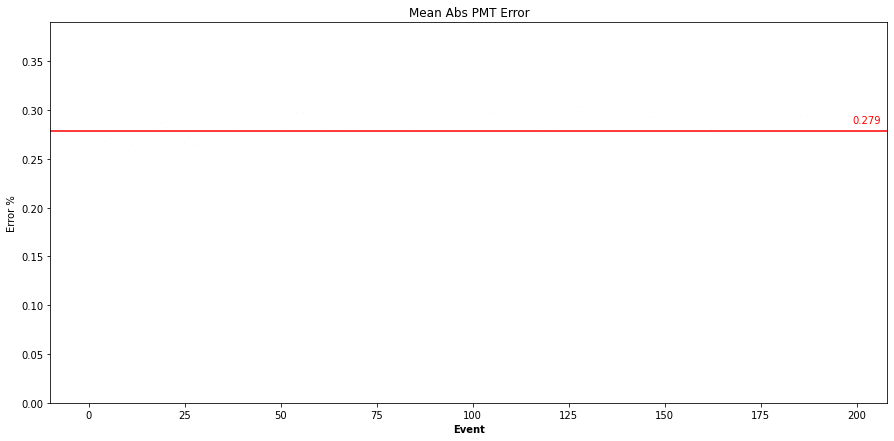

In [141]:
### Plotting the error across all events

# set width of bar
barWidth = 0.25

# Set position of bar on X axis
r1 = np.arange(len(errorArr))
 
# Make the plot
plt.rcParams["figure.figsize"] = (15,7)
plt.bar(r1, errorArr, color='#3464eb', width=barWidth, edgecolor='white')
 
# Add xticks on the middle of the group bars
plt.xlabel('Event', fontweight='bold')
plt.ylabel("Error %")
plt.axhline(y=meanAccuracy, color='r', linestyle='-')
plt.text(n-1,meanAccuracy+(meanAccuracy/35),meanAccuracy,color='r')
plt.title("Mean Abs PMT Error")
#plt.xticks([r + barWidth for r in range(len(errorArr))], digiEvents[1:])
 
# Create legend & Show graphic

plt.show()

In [ ]:
digiArr = np.load("digiHitsOffsetArr.npy")



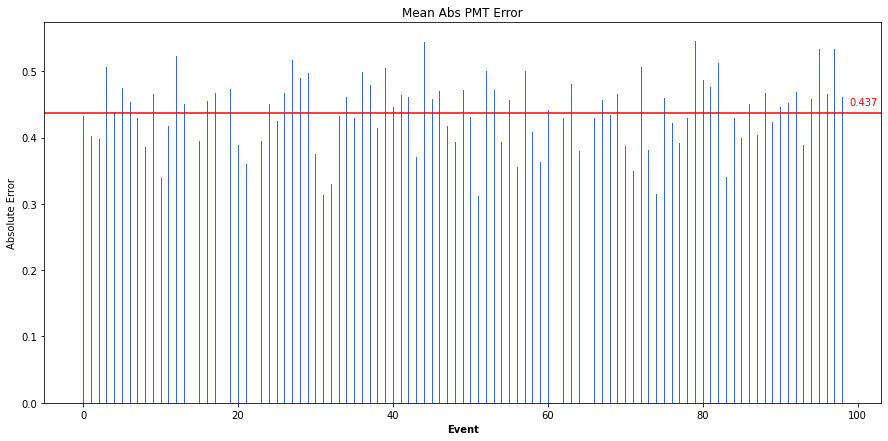

In [120]:
### Plotting the error across all events

# set width of bar
barWidth = 0.25

# Set position of bar on X axis
r1 = np.arange(len(errorArr))
 
# Make the plot
plt.rcParams["figure.figsize"] = (15,7)
plt.bar(r1, absErrorArr, color='#3464eb', width=barWidth, edgecolor='white')
 
# Add xticks on the middle of the group bars
plt.xlabel('Event', fontweight='bold')
plt.ylabel("Absolute Error")
plt.axhline(y=meanAbsAccuracy, color='r', linestyle='-')
plt.text(n-1,meanAbsAccuracy+(meanAbsAccuracy/35),meanAbsAccuracy,color='r')
plt.title("Mean Abs PMT Error")
#plt.xticks([r + barWidth for r in range(len(errorArr))], digiEvents[1:])
 
# Create legend & Show graphic

plt.show()

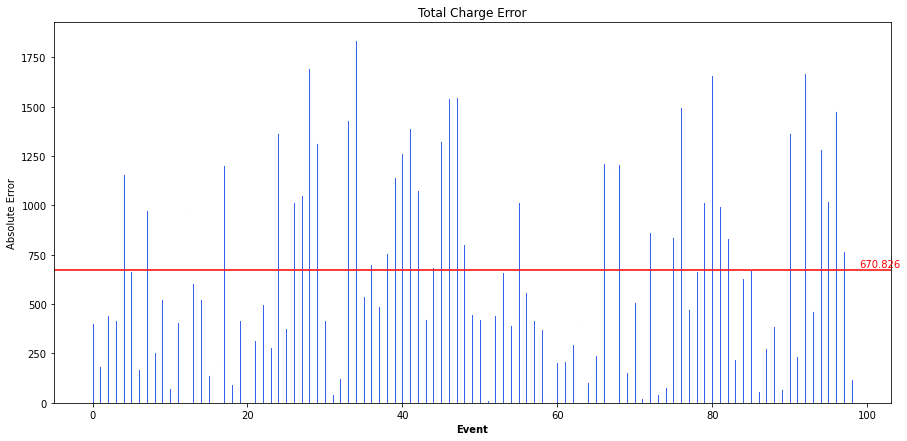

In [121]:
### Plotting the error across all events

# set width of bar
barWidth = 0.25

# Set position of bar on X axis
r1 = np.arange(len(sumDiff))
 
# Make the plot
plt.rcParams["figure.figsize"] = (15,7)
plt.bar(r1, sumDiff, color='#3464eb', width=barWidth, edgecolor='white')
 
# Add xticks on the middle of the group bars
plt.xlabel('Event', fontweight='bold')
plt.ylabel("Absolute Error")
plt.axhline(y=meanChargeDiff, color='r', linestyle='-')
plt.text(n-1,meanChargeDiff+(meanChargeDiff/35),meanChargeDiff,color='r')
plt.title("Total Charge Error")
#plt.xticks([r + barWidth for r in range(len(errorArr))], digiEvents[1:])
 
# Create legend & Show graphic

plt.show()